In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("../data/CC2020_train_final.csv")

In [3]:
grp_df = pd.read_csv("../data/grouped_data.csv")
grp_df.drop(labels=grp_df.columns[0], axis=1, inplace=True)
grp_df.head()

,INBRED,TESTER,mean
0,Inbred_1071,Tester_1345,0.986544
1,Inbred_1071,Tester_4373,1.057704
2,Inbred_1071,Tester_4473,1.023704
3,Inbred_1071,Tester_4541,1.014735
4,Inbred_1071,Tester_5305,1.062727


In [4]:
mat = grp_df.pivot(index='INBRED', columns='TESTER', values='mean').values

In [5]:
train_df = grp_df.pivot(index='INBRED', columns='TESTER', values='mean')

In [6]:
type(mat)

numpy.ndarray

In [7]:
nonzero = []
for i in range(mat.shape[1]):
    nonzero.append(sum(~np.isnan(mat[:,i]))) 

In [8]:
import matplotlib.pyplot as plt

(array([290., 117.,  40.,  23.,  11.,   4.,   3.,   3.,   2.,   3.]),
 array([  1. ,  16.6,  32.2,  47.8,  63.4,  79. ,  94.6, 110.2, 125.8,
        141.4, 157. ]),
 <a list of 10 Patch objects>)

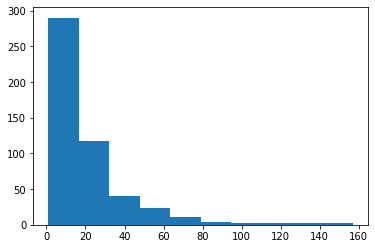

In [9]:
plt.hist(nonzero)

In [10]:
dict_ = {k: (~train_df[k].isnull()).sum() for k in train_df.columns}
sorted_d = sorted(dict_.items(), key=lambda x: x[1])

In [11]:
test_df = train_df.copy()
test_df = test_df * 0

In [83]:
# creating test data
np.random.seed(5)
min_sel = 1
picked = set()
for col , num in sorted_d:
    if num > min_sel:
        full_col = train_df[col]
        indices = train_df[~full_col.isnull()].index
#         print(indices)
        indices = [ind for ind in indices if ind not in picked]
        if len(indices) > 0:
            pick = np.random.choice(indices, size = max(1, len(indices)//10))
            for i in indices:
                picked.add(i)
            for p in pick:
                test_df.loc[p, col] = train_df.loc[p, col]
                train_df.loc[p, col] = 0
    

In [84]:
train_df.fillna(0.0, inplace=True)
test_df.fillna(0.0, inplace=True)

In [54]:
class MF():
    
    def __init__(self, R, K, alpha, beta, iterations, lambda_bias, test=None):
        """
        Perform matrix factorization to predict empty
        entries in a matrix.
        
        Arguments
        - R (ndarray)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - beta (float)  : regularization parameter
        """
        
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.lambda_bias = lambda_bias
        self.iterations = iterations
        self.test = test

    def train(self):
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))
        
        # Initialize the biases
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])
        
        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]
        
        # Perform stochastic gradient descent for number of iterations
        training_process = []
        test_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 10 == 0:
#                 print("Iteration: %d ; error = %.4f" % (i+1, mse))
                temp_pred = self.full_matrix()
                test_process.append(get_mse(temp_pred, self.test))
        
        return training_process, test_process

    def mse(self):
        """
        A function to compute the total mean square error
        """
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        error /= len(xs)
        return np.sqrt(error)

    def sgd(self):
        """
        Perform stochastic graident descent
        """
        for i, j, r in self.samples:
            # Computer prediction and error
            prediction = self.get_rating(i, j)
            e = (r - prediction)
            
            # Update biases
            self.b_u[i] += self.alpha * (e - self.lambda_bias * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.lambda_bias * self.b_i[j])
            
            # Create copy of row of P since we need to update it but use older values for update on Q
            P_i = self.P[i, :][:]
            
            # Update user and item latent feature matrices
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * P_i - self.beta * self.Q[j,:])

    def get_rating(self, i, j):
        """
        Get the predicted rating of user i and item j
        """
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction
    
    def full_matrix(self):
        """
        Computer the full matrix using the resultant biases, P and Q
        """
        return mf.b_u[:,np.newaxis] + mf.b_i[np.newaxis:,] + mf.P.dot(mf.Q.T)  + mf.b



In [55]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [27]:
kmax = 30
ks  = range(2, kmax+1, 2)
alphas = [10**i for i in range(-5,0)]
betas = [10**i for i in range(-5,0)]
lambdas = [10**i for i in range(-5,0)]
best_test_error = {}
for k in ks:
    print(f'running k = {k}')
    if k > 5:
        for a in alphas:
            for beta in betas:
                for lambda_bias in lambdas:
                    
                    mf = MF(train_df.values, K=k, alpha=a, beta=beta, iterations=300, lambda_bias=lambda_bias, test=test_df.values)
                    training_process, test_process = mf.train()
                    best_test_error[(k, a, beta, lambda_bias)] = min(test_process)

running k = 2
running k = 4
running k = 6
running k = 8
running k = 10
running k = 12
running k = 14
running k = 16
running k = 18
running k = 20
running k = 22
running k = 24
running k = 26
running k = 28
running k = 30


In [64]:
line

'(26, 0.001, 0.001, 1e-05), 0.0027260186574101183\n'

In [75]:
line[1:].split(',')

['26', ' 0.001', ' 0.001', ' 1e-05)', ' 0.0027260186574101183\n']

In [91]:
def _split(line):
    '''split a line and return the parameters we are interested in '''
    #line = line.trim()
    k, a, beta, lambda_bias, _ = [float(item) if i < 3 else item[:-1] \
                                  for i, item in enumerate(line[1:].split(','))]
    return int(k), a, beta, float(lambda_bias)

file_name = 'results.txt'
file = open(file_name, 'r')
to_write = open('split3_k35.txt', 'a')
for line in file:
    best_test_error = {}
    k, a, beta, lambda_bias = _split(line)
    mf = MF(train_df.values, K=30, alpha=a, beta=beta, iterations=100, lambda_bias=lambda_bias, test=test_df.values)
    training_process, test_process = mf.train()
    best_test_error[(k, a, beta, lambda_bias)] = min(test_process)
    # save in a file
    break
    to_write.write(str(best_test_error.items()))
    to_write.write("\n")
    print(min(test_process))
to_write.close()
file.close()

In [99]:
mf = MF(train_df.values, 26, 0.001, 0.001, 300, 1e-05, test=test_df.values)
training_process, test_process = mf.train()

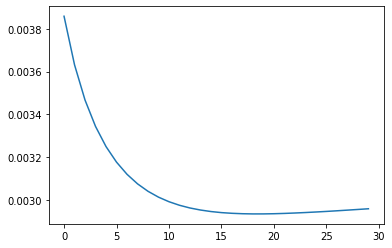

In [100]:
plt.plot(test_process)

In [90]:
test_process

[0.0028962249137515586,
 0.002819793608426278,
 0.0028426597225839983,
 0.002872832151831528,
 0.002901468305066955,
 0.0029279647507372097,
 0.0029474346744742196,
 0.0029661750981782855,
 0.002981160570220183,
 0.002994108605067302,
 0.0030084893494675344,
 0.0030148946129061717,
 0.003027225691010987,
 0.0030347061271523436,
 0.00304477980475793,
 0.003049547340743213,
 0.0030585111209421923,
 0.003060750360544173,
 0.0030685414260405524,
 0.0030723990482643846,
 0.003076777835988558,
 0.0030773964528941307,
 0.0030792075680774753,
 0.003080556316395245,
 0.003082238175067082,
 0.003083016357754063,
 0.0030863282419726877,
 0.0030834622012222567,
 0.003084214661589409,
 0.0030848699057036584]

In [79]:
to_write = open('split1.txt', 'a')
to_write.write("a\\n")
to_write.close()

In [28]:
# mf = MF(train_df.values, K=10, alpha=0.01, beta=0.1, iterations=300, lambda_bias=0.15, test=test_df.values)
# training_process, test_process = mf.train()

(array([3.4000e+01, 6.5600e+02, 6.4410e+03, 4.0144e+04, 1.2346e+05,
        1.0554e+05, 1.6641e+04, 8.0100e+02, 3.2500e+02, 8.6000e+01]),
 array([0.77677574, 0.82165444, 0.86653314, 0.91141183, 0.95629053,
        1.00116923, 1.04604792, 1.09092662, 1.13580532, 1.18068401,
        1.22556271]),
 <a list of 10 Patch objects>)

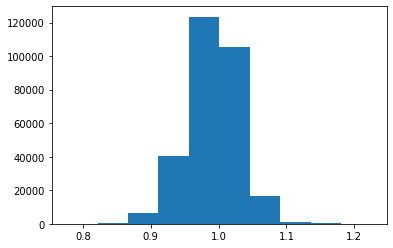

In [24]:
plt.hist(mf.full_matrix().flatten())

In [29]:
best_test_error

{(6, 1e-05, 1e-05, 1e-05): 0.008885469738702868,
 (6, 1e-05, 1e-05, 0.0001): 0.00809057798037285,
 (6, 1e-05, 1e-05, 0.001): 0.008526277998448458,
 (6, 1e-05, 1e-05, 0.01): 0.007658705409749787,
 (6, 1e-05, 1e-05, 0.1): 0.009303150580905575,
 (6, 1e-05, 0.0001, 1e-05): 0.010049781924492629,
 (6, 1e-05, 0.0001, 0.0001): 0.008571120286831628,
 (6, 1e-05, 0.0001, 0.001): 0.008707305845104903,
 (6, 1e-05, 0.0001, 0.01): 0.010177979352572957,
 (6, 1e-05, 0.0001, 0.1): 0.008094645701388488,
 (6, 1e-05, 0.001, 1e-05): 0.009102519424874557,
 (6, 1e-05, 0.001, 0.0001): 0.009670380716355237,
 (6, 1e-05, 0.001, 0.001): 0.009554407121516664,
 (6, 1e-05, 0.001, 0.01): 0.007798748012888805,
 (6, 1e-05, 0.001, 0.1): 0.009402858126614401,
 (6, 1e-05, 0.01, 1e-05): 0.007970454612244883,
 (6, 1e-05, 0.01, 0.0001): 0.00784530006258138,
 (6, 1e-05, 0.01, 0.001): 0.007807517594564667,
 (6, 1e-05, 0.01, 0.01): 0.007166734404658494,
 (6, 1e-05, 0.01, 0.1): 0.009035078511882769,
 (6, 1e-05, 0.1, 1e-05): 0.007

In [44]:
ordered_results = sorted(best_test_error.items(), key=lambda x: x[1])

In [86]:
ordered_results

[((26, 0.001, 0.001, 1e-05), 0.0027260186574101183),
 ((24, 0.01, 1e-05, 0.001), 0.0027370889092149567),
 ((22, 0.001, 0.01, 1e-05), 0.002755398439789228),
 ((26, 0.01, 1e-05, 0.001), 0.0027588146940080477),
 ((20, 0.001, 0.001, 0.01), 0.002762529417228305),
 ((30, 0.01, 0.0001, 0.01), 0.002763191240602552),
 ((28, 0.001, 0.01, 0.001), 0.002763730001994065),
 ((22, 0.01, 0.0001, 0.01), 0.002767020310235907),
 ((26, 0.01, 0.0001, 0.1), 0.002767206118311563),
 ((20, 0.01, 0.1, 1e-05), 0.0027684106036501765),
 ((26, 0.001, 1e-05, 0.0001), 0.0027684583927108054),
 ((30, 0.001, 0.001, 1e-05), 0.002770945154257955),
 ((22, 0.001, 0.1, 0.0001), 0.0027710220514274336),
 ((18, 0.001, 0.001, 0.0001), 0.0027744762316897847),
 ((30, 0.001, 0.001, 0.1), 0.0027745860228178066),
 ((24, 0.01, 0.01, 0.1), 0.0027755648873125922),
 ((26, 0.001, 1e-05, 1e-05), 0.002776347425961026),
 ((26, 0.001, 0.1, 0.1), 0.002778446183093667),
 ((24, 0.01, 0.001, 0.1), 0.0027834372251950763),
 ((20, 0.01, 0.001, 1e-05)

In [39]:
best_test_error.itertuple()

AttributeError: 'dict' object has no attribute 'itertuple'

In [32]:
max(best_test_error.values())

0.010177979352572957

In [51]:
# elements = [val for i, val in enumerate(ordered_results) if i < 20]
count = 0
with open('results.txt', 'w') as f:
    while count < 20:
        val = ordered_results[count]
        f.write(str(val)[1:-1] + '\n')
        count +=1
